Language models take **text** as input and predict which **text** should come next. Taking that into consideration, what does _function calling_ even mean?

In this post, I start by providing a basic example to motivate function calling, then I give a slightly more complex example by allowing a small language model to use Python. After that, I explain the *conversational response as a tool* trick. Finally, I explain how to do function calling in WebAssembly (optional but fun if you want to try function calling in the browser in this post itself).

## Basic example

Let's start with a basic example. Imagine that we ask a language model to perform the multiplication of `1234567` times `8765432` whose result is:

In [1]:
#| echo: false
import warnings
warnings.filterwarnings("ignore")

In [2]:
#| echo: true
print(f"{1234567*8765432:,}")

10,821,513,087,944


This is the answer of the language model:

In [5]:
#| code-fold: true
#| code-summary: "Show the code"
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "Qwen/Qwen3-0.6B"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id, cache_dir="/big_storage/llms/hf_models/"
).to("cuda")

messages = [
    {"role": "user", "content": "What's 1234567 times 8765432?"},
]

prompt = tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True, enable_thinking=False
)
model_inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
prompt_length = model_inputs["input_ids"].shape[1]
outputs = model.generate(
    **model_inputs,
    max_new_tokens=1024,
    do_sample=False,
    temperature=1.0,
    top_p=1.0,
    top_k=50,
)
assistant_response = tokenizer.decode(outputs[0][prompt_length:])
print(assistant_response)

To find the product of **1234567 × 8765432**, we can use a calculator or a multiplication table. However, since this is a large number, it's best to use a calculator or a computational tool.

### Final Answer:
$$
1234567 \times 8765432 = \boxed{10999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999

This model is not particularly good but even GPT-4o-mini fails without using function calling:

![](ChatGPT-multiplication.jpg)

Here is the [link to that conversation](https://chatgpt.com/s/t_686901e99a648191815170ed3c83083b).

An analogy of function calling is that to ask a language model directly to perform a computation is similar to ask someone to make that computation in his head. It's hard! However, if we gave him a calculator, he could solve it quite easily. He needs to know only two things:

1. which operation (or function) to use
2. which numbers (or arguments) to use

The same is true for doing function calling with a language model. It needs to know which function and which arguments to use.

Let's provide a description of a function to the language model so it knows what's the function name and which are the arguments the function expects. 

You can provide the description manually (after all it's just **text**) but I will use Pydantic to do that. Here is the description of the `multiply` function

In [8]:
#| code-fold: true
#| code-summary: "Show the code"
from pydantic import BaseModel, Field
import json
from openai import pydantic_function_tool

class multiply(BaseModel):
    """Multiply two integers together."""

    a: int = Field(..., description="First integer")
    b: int = Field(..., description="Second integer")

tool = pydantic_function_tool(multiply)
print(json.dumps(tool, indent=4))

{
    "type": "function",
    "function": {
        "name": "multiply",
        "strict": true,
        "parameters": {
            "description": "Multiply two integers together.",
            "properties": {
                "a": {
                    "description": "First integer",
                    "title": "A",
                    "type": "integer"
                },
                "b": {
                    "description": "Second integer",
                    "title": "B",
                    "type": "integer"
                }
            },
            "required": [
                "a",
                "b"
            ],
            "title": "multiply",
            "type": "object",
            "additionalProperties": false
        },
        "description": "Multiply two integers together."
    }
}


After we have provided a function/tool description, we can see if the model knows what to do with it:

In [16]:
#| code-fold: true
#| code-summary: "Show the code"
prompt = tokenizer.apply_chat_template(
    messages, tools=[tool], tokenize=False, add_generation_prompt=True, enable_thinking=False
)
model_inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
prompt_length = model_inputs["input_ids"].shape[1]
outputs = model.generate(
    **model_inputs,
    max_new_tokens=1024,
    do_sample=False,
    temperature=1.0,
    top_p=1.0,
    top_k=50,
)
assistant_response = tokenizer.decode(outputs[0][prompt_length:], skip_special_tokens=True)
print(assistant_response)

<tool_call>
{"name": "multiply", "arguments": {"a": 1234567, "b": 8765432}}
</tool_call>


Even this small model is able to get correctly:

- the function name (`multiply`)
- the arguments to provide to the function (`1234567` and `8765432`)

Notice that we have not yet implemented the function itself (!), which we might or might not do (as we will see in other examples next).

We can get the assistant response and simply do the multiplication ourselves. This is important, what we call function calling in reality is the model telling us which function to call and which arguments to provide to that function. It is up to us to run or not that function. In this case, we will run it:

In [18]:
#| code-fold: true
#| code-summary: "Show the code"
assistant_response_clean = assistant_response.split("<tool_call>")[-1].split("</tool_call>")[0]
assistant_response_json = json.loads(assistant_response_clean)

def execute_function_call(assistant_response_json):
    if assistant_response_json['name'] == 'multiply':
        tool_response = assistant_response_json['arguments']['a']*assistant_response_json['arguments']['b']
    else:
        tool_response = assistant_response_clean
    return tool_response

tool_response = execute_function_call(assistant_response_json)
print(f"{tool_response:,}")

10,821,513,087,944


This is great. We already got the correct answer! However, we usually want to have a more "human" response. To do that we can append two messages (a message for the function call and another for the tool response:

In [19]:
#| code-fold: true
#| code-summary: "Show the code"
messages.append({
    "role": "assistant",
    "content": "",
    "function_call": None,
    "tool_calls": [{
        "name": assistant_response_json["name"],
        "arguments": assistant_response_json["arguments"],
    }],
})

messages.append(
    {
        "role": "tool",
        "content": f"{tool_response}",
    }
)

Since we have full control in this setting, we can actually see what's the **text** the language model is receiving as input:

In [20]:
#| code-fold: true
#| code-summary: "Show the code"
prompt = tokenizer.apply_chat_template(
    messages,
    tools=[tool],
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=False,
)
print(prompt)

<|im_start|>system
# Tools

You may call one or more functions to assist with the user query.

You are provided with function signatures within <tools></tools> XML tags:
<tools>
{"type": "function", "function": {"name": "multiply", "strict": true, "parameters": {"description": "Multiply two integers together.", "properties": {"a": {"description": "First integer", "title": "A", "type": "integer"}, "b": {"description": "Second integer", "title": "B", "type": "integer"}}, "required": ["a", "b"], "title": "multiply", "type": "object", "additionalProperties": false}, "description": "Multiply two integers together."}}
</tools>

For each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:
<tool_call>
{"name": <function-name>, "arguments": <args-json-object>}
</tool_call><|im_end|>
<|im_start|>user
What's 1234567 times 8765432?<|im_end|>
<|im_start|>assistant
<tool_call>
{"name": "multiply", "arguments": {"a": 1234567, "b": 8765432}}
</

We can then make a call to the model to provide a "human" response:

In [21]:
#| code-fold: true
#| code-summary: "Show the code"
model_inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
prompt_length = model_inputs["input_ids"].shape[1]
outputs = model.generate(
    **model_inputs,
    max_new_tokens=1024,
    do_sample=False,
    temperature=1.0,
    top_p=1.0,
    top_k=50,
)
assistant_response = tokenizer.decode(outputs[0][prompt_length:], skip_special_tokens=True)
print(assistant_response)

1234567 × 8765432 = 10821513087944


OK, this response is correct and more "human". It could be improved but that's because it's a very small model.

I hope you realize that even a small language model (in this example, with 0.6B parameters) provided with a function/tool can answer better that question than a powerful model such as GPT-4o-mini.

That's powerful!

## Language Model Using Python

In our basic example, we used a very tailored function because I wanted to show that function calling can use several arguments. We can however provided with a Python REPL which will allow us to use a pletora of tools in Python. Here is a description of a Python REPL:

In [24]:
#| code-fold: true
#| code-summary: "Show the code"
class Python_REPL(BaseModel):
    "A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`."

    python_code: str = Field(..., description="Valid python command.")

tool = pydantic_function_tool(Python_REPL)
print(json.dumps(tool, indent=4))

{
    "type": "function",
    "function": {
        "name": "Python_REPL",
        "strict": true,
        "parameters": {
            "description": "A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
            "properties": {
                "python_code": {
                    "description": "Valid python command.",
                    "title": "Python Code",
                    "type": "string"
                }
            },
            "required": [
                "python_code"
            ],
            "title": "Python_REPL",
            "type": "object",
            "additionalProperties": false
        },
        "description": "A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`."
    }
}


We can ask our model to, for example, `make a bar plot`. In this case, the language model couldn't figure out what to do:

In [27]:
#| code-fold: true
#| code-summary: "Show the code"
messages = [
    {"role": "user", "content": "Make a bar plot"},
]

prompt = tokenizer.apply_chat_template(
    messages, tools=[tool], tokenize=False, add_generation_prompt=True, enable_thinking=False
)
model_inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
prompt_length = model_inputs["input_ids"].shape[1]
outputs = model.generate(
    **model_inputs,
    max_new_tokens=1024,
    do_sample=False,
    temperature=1.0,
    top_p=1.0,
    top_k=50,
)
assistant_response = tokenizer.decode(outputs[0][prompt_length:], skip_special_tokens=True)
print(assistant_response)

I cannot make a bar plot directly, but I can help you create one using Python. Could you please provide the data you want to plot?


The model was unable to call the tool but we can help it by adding it directly to the prompt (notice that this is equivalent to `add_generation_prompt=True` when we apply the chat template). This is probably [what OpenAI does](https://platform.openai.com/docs/guides/function-calling/function-calling-behavior?api-mode=chat#additional-configurations) with the option `tool_choice=required` and we could even impose which tool to call which is probably equivalent to the forced function option that OpenAI provides). Let's add the tool call directly to the prompt:

In [28]:
#| code-fold: true
#| code-summary: "Show the code"
prompt += "<tool_call>" # added directly to the prompt
model_inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
prompt_length = model_inputs["input_ids"].shape[1]
outputs = model.generate(
    **model_inputs,
    max_new_tokens=1024,
    do_sample=False,
    temperature=1.0,
    top_p=1.0,
    top_k=50,
)
assistant_response = "<tool_call>" + tokenizer.decode(outputs[0][prompt_length:], skip_special_tokens=True) # it was added to the prompt
print(assistant_response)

<tool_call>
{"name": "Python_REPL", "arguments": {"python_code": "import matplotlib.pyplot as plt\nplt.bar([1, 2, 3], [10, 20, 30])\nplt.show()"}}
</tool_call>


This small model was able to provide the code to do a bar plot. It is up to us to run or not that code. In this case, we will run it:

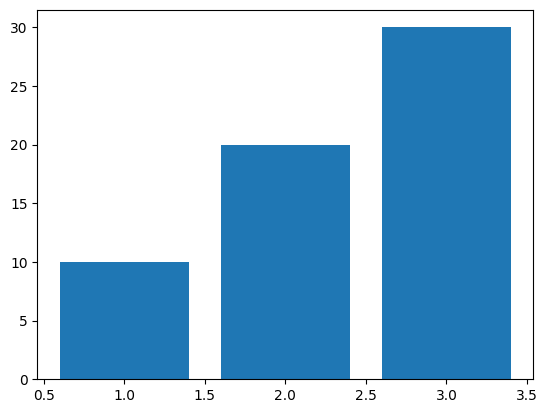

In [34]:
#| code-fold: true
#| code-summary: "Show the code"
assistant_response_clean = assistant_response.split("<tool_call>")[-1].split("</tool_call>")[0]
assistant_response_json = json.loads(assistant_response_clean)

def execute_function_call(assistant_response_json):
    if assistant_response_json['name'] == 'Python_REPL':
        tool_response = exec(assistant_response_json['arguments']['python_code'])
    else:
        tool_response = assistant_response_json
    return tool_response

execute_function_call(assistant_response_json)

By imposing that the language model needs to call a tool, we cannot let the model to respond to a conversational question. For example to `tell us a joke`:

In [36]:
#| code-fold: true
#| code-summary: "Show the code"
messages = [
    {"role": "user", "content": "Tell me a joke"},
]

prompt = tokenizer.apply_chat_template(
    messages, tools=[tool], tokenize=False, add_generation_prompt=True, enable_thinking=False
)
prompt += "<tool_call>" # imposed tool call
model_inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
prompt_length = model_inputs["input_ids"].shape[1]
outputs = model.generate(
    **model_inputs,
    max_new_tokens=1024,
    do_sample=False,
    temperature=1.0,
    top_p=1.0,
    top_k=50,
)
assistant_response = "<tool_call>" + tokenizer.decode(outputs[0][prompt_length:], skip_special_tokens=True)
print(assistant_response)

<tool_call>
{"name": "Python_REPL", "arguments": {"python_code": "print('Hello, world!')"}}
</tool_call>


We could use a trick. We could provide a "tool" to get back that behavior. Let's give a description of that "tool":

In [38]:
#| code-fold: true
#| code-summary: "Show the code"
class ConversationalResponse(BaseModel):
    """Respond in a conversational manner. Be kind and helpful."""

    response: str = Field(description="A conversational response to the user's query")
tool_conversational_response = pydantic_function_tool(ConversationalResponse)
print(json.dumps(tool_conversational_response, indent=4))

{
    "type": "function",
    "function": {
        "name": "ConversationalResponse",
        "strict": true,
        "parameters": {
            "description": "Respond in a conversational manner. Be kind and helpful.",
            "properties": {
                "response": {
                    "description": "A conversational response to the user's query",
                    "title": "Response",
                    "type": "string"
                }
            },
            "required": [
                "response"
            ],
            "title": "ConversationalResponse",
            "type": "object",
            "additionalProperties": false
        },
        "description": "Respond in a conversational manner. Be kind and helpful."
    }
}


In [39]:
#| code-fold: true
#| code-summary: "Show the code"
messages = [
    {"role": "user", "content": "Tell me a joke"},
]

prompt = tokenizer.apply_chat_template(
    messages, tools=[tool, tool_conversational_response], tokenize=False, add_generation_prompt=True, enable_thinking=False
)
prompt += "<tool_call>" # imposed tool call
model_inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
prompt_length = model_inputs["input_ids"].shape[1]
outputs = model.generate(
    **model_inputs,
    max_new_tokens=1024,
    do_sample=False,
    temperature=1.0,
    top_p=1.0,
    top_k=50,
)
assistant_response = "<tool_call>" + tokenizer.decode(outputs[0][prompt_length:], skip_special_tokens=True)
print(assistant_response)

<tool_call>
{"name": "ConversationalResponse", "arguments": {"response": "Here's a joke for you: A man in a hat with a hat on it, a hat with a hat on it, and a hat with a hat on it... It's a hat with a hat on it!"}}
</tool_call>


In [40]:
assistant_response_clean = assistant_response.split("<tool_call>")[-1].split("</tool_call>")[0]
assistant_response_json = json.loads(assistant_response_clean)

def execute_function_call(assistant_response_json):
    if assistant_response_json['name'] == 'Python_REPL':
        tool_response = exec(assistant_response_json['arguments']['python_code'])
    elif assistant_response_json['name'] == 'ConversationalResponse':
        tool_response = assistant_response_json['arguments']['response']
    else:
        tool_response = assistant_response_json
    return tool_response

execute_function_call(assistant_response_json)

"Here's a joke for you: A man in a hat with a hat on it, a hat with a hat on it, and a hat with a hat on it... It's a hat with a hat on it!"

Not clear that it's a good joke but we got back the behavior we were expecting.

## WebAssembly

We can run the previous code in the browser thanks to WebAssembly!

We first need to install some packages:

```{pyodide-python}
import micropip

await micropip.install("numpy")
await micropip.install("matplotlib")
await micropip.install("openai")
await micropip.install("transformers_js_py")
print("Packages installation completed.")
```

We can download a quantized version of the model we used (not everything will work but most of it will). This step should take a few minutes the first time (later it should be stored in the cache):

```{pyodide-python}
import json
import numpy as np
from transformers_js_py import import_transformers_js
from openai import pydantic_function_tool
from pydantic import BaseModel, Field

transformers = await import_transformers_js()

model_id = 'onnx-community/Qwen3-0.6B-ONNX'

AutoTokenizer = transformers.AutoTokenizer
tokenizer = await AutoTokenizer.from_pretrained(model_id)

AutoModelForCausalLM = transformers.AutoModelForCausalLM
model = await AutoModelForCausalLM.from_pretrained(model_id)
print("Model downloaded.")
```

We can send a prompt:

```{pyodide-python}
user_input = "Make a bar plot with values 1, 2, and 3"
print("Prompt received.")
```

We can define the tools and tokenize the prompt:

```{pyodide-python}
messages = [
    {"role": "user", "content": user_input},
]

class Python_REPL(BaseModel):
    "A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`."

    python_code: str = Field(..., description="Valid python command.")

tool_Python_REPL = pydantic_function_tool(Python_REPL)

print("Tool definition ready.")

prompt = tokenizer.apply_chat_template(
    messages, tools=[tool_Python_REPL], tokenize=False, add_generation_prompt=True, enable_thinking=False
)
prompt += "<tool_call>" # imposed tool call

inputs = tokenizer(prompt)

up = np.array(inputs["input_ids"].tolist(), dtype=np.uint32)
prompt_length = up.shape[1]
print("Prompt tokenized.")
```

This is the generation part and it can take one or two minutes:

```{pyodide-python}
outputs = await model.generate(
    **inputs, max_new_tokens=1024, do_sample=False
)

print("outputs ready.")
```

This is the generated code:

```{pyodide-python}
ar = np.array(outputs.tolist(), dtype=np.uint32)
assistant_response = "<tool_call>" + tokenizer.decode([int(token) for token in ar[0]][prompt_length:], skip_special_tokens=True)
print(assistant_response)
```

We can execute the code:

```{pyodide-python}
def execute_function_call(assistant_response):
    assistant_response_clean = assistant_response.split("<tool_call>")[-1].split("</tool_call>")[0]
    assistant_response_json = json.loads(assistant_response_clean)
    if assistant_response_json['name'] == 'Python_REPL':
        tool_response = exec(assistant_response_json['arguments']['python_code'])
    elif assistant_response_json['name'] == 'ConversationalResponse':
        tool_response = assistant_response_json['arguments']['response']
    else:
        tool_response = assistant_response_json
    return tool_response

execute_function_call(assistant_response)
```

Feel free to modify the code and/or prompts and run them in the browser!